In [1]:
import z3
import numpy as np
from functools import cache
from pprint import pprint
%load_ext line_profiler

from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import itertools
import networkx as nx
from tqdm import tqdm
from io import BytesIO
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import html

In [3]:
import sys
sys.path.append('../')
sys.path.append('../model/')

import simulation
import analysis
import grammar
reload(simulation)
reload(analysis)
reload(grammar)

<module 'grammar' from '/mnt/c/Users/faust/OneDrive - UvA/research_projects/2024_pLoTRSA/pLOT_RSA/case_studies/../model/grammar.py'>

In [4]:
from Models import BooleanModel
from QUD import ProductQUD
from analysis import parse, already_defined, analyse_specific_hyps
from simulation import infer_meaning
from grammar import define_grammar
from utilities import (               
    find_phonform_possible_structures,
    print_possible_parses         
)

# Plotting functions

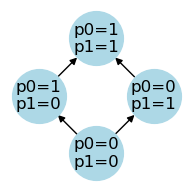

In [260]:
# Number of Boolean propositions (assumed to be 2)
n_props = 2

# Generate all 2^n truth assignments.
assignments = list(itertools.product([True, False], repeat=n_props))

# Create compact labels for each assignment.
# For example, (True, False) becomes:
# "p0=1\np1=0"
labels = {
    a: '\n'.join(f"p{i}={'1' if a[i] else '0'}" for i in range(n_props))
    for a in assignments
}

# Define the partial order: a <= b if for each proposition,
# whenever a[i] is True then b[i] is also True.
def is_less(a, b):
    if a == b:
        return False
    for i in range(n_props):
        if a[i] and not b[i]:
            return False
    return True

# Build the Hasse diagram (covering graph).
G = nx.DiGraph()
for a in assignments:
    G.add_node(a)
for a in assignments:
    for b in assignments:
        if is_less(a, b):
            # Only add an edge if there is no intermediate c with a < c < b.
            is_cover = True
            for c in assignments:
                if c != a and c != b and is_less(a, c) and is_less(c, b):
                    is_cover = False
                    break
            if is_cover:
                G.add_edge(a, b)

# For 2 variables, manually assign positions to form a rotated square (diamond).
# Swap the mid-layer positions so that (True, False) appears on the left.
pos = {
    (False, False): (0, -1),
    (True, False): (-1, 0),  # now on the left
    (False, True): (1, 0),   # now on the right
    (True, True): (0, 1)
}

# Create the figure with a small square size.
fig, ax = plt.subplots(figsize=(2,2))
nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightblue',
        node_size=1500, arrows=True, ax=ax)

padding = 0.5
ax.set_xlim(min(x for x, y in pos.values()) - padding,
            max(x for x, y in pos.values()) + padding)
ax.set_ylim(min(y for x, y in pos.values()) - padding,
            max(y for x, y in pos.values()) + padding)

plt.tight_layout(pad=1.0)  # Adjust the padding around the figure

plt.savefig('figures/diagram.png', dpi=300)

In [11]:
def get_hasse_diagram_for_expr(expr, n_props=2, figsize=(2,2), draw_labels=False, returnimage=True):
    """
    Given a Z3 Boolean expression (assumed to be on variables named p0, p1, ...),
    this function generates a Hasse diagram image of all assignments (with the 
    satisfying ones colored green, and others red).
    """
    # Enumerate all assignments for n_props booleans.
    all_assignments = list(itertools.product([False, True], repeat=n_props))
    satisfying_assignments = set()
    
    # Helper for substitution mapping.
    def subs_map(assignment):
        return [(z3.Bool(f'p{i}'), z3.BoolVal(val)) for i, val in enumerate(assignment)]
    
    for assignment in all_assignments:
        subs = subs_map(assignment)
        result = z3.simplify(z3.substitute(expr, subs))
        if z3.is_true(result):
            satisfying_assignments.add(assignment)
    
    # Partial order: a <= b if for each proposition, if a[i] is True then b[i] is True.
    def is_less(a, b):
        if a == b:
            return False
        return all((not a[i]) or b[i] for i in range(n_props))
    
    # Build the graph and assign labels.
    G = nx.DiGraph()
    labels = {}
    for a in all_assignments:
        # Use a compact label format: one line per variable.
        label = '\n'.join(f"p{i}={'1' if a[i] else '0'}" for i in range(n_props))
        labels[a] = label
        G.add_node(a)
    for a in all_assignments:
        for b in all_assignments:
            if is_less(a, b):
                is_cover = True
                for c in all_assignments:
                    if c != a and c != b and is_less(a, c) and is_less(c, b):
                        is_cover = False
                        break
                if is_cover:
                    G.add_edge(a, b)
    
    # Create a custom layered layout: y coordinate = number of True values.
    layers = {}
    for a in all_assignments:
        level = sum(a)
        layers.setdefault(level, []).append(a)
    pos = {}
    for level, nodes in layers.items():
        nodes_sorted = sorted(nodes, reverse=True)
        count = len(nodes_sorted)
        for i, a in enumerate(nodes_sorted):
            x = (i - (count - 1) / 2) * 1.5
            y = level
            pos[a] = (x, y)
    
    node_colors = ["green" if a in satisfying_assignments else "red" for a in all_assignments]
    
    # Draw the diagram off-screen.
    fig, ax = plt.subplots(figsize=figsize)
    nx.draw(
        G, 
        pos, 
        with_labels=draw_labels, 
        labels=labels, 
        node_color=node_colors,
        node_size=500, 
        arrows=True, 
        ax=ax
    )
    ax.set_axis_off()
    if returnimage:
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close(fig)
        buf.seek(0)
        img = mpimg.imread(buf)
        return img
    else:
        return fig, ax

def plot_results(dictionary, solver, dict_type='tn', first_n=None, ignore_parse=False, figsize=(7,3)):
    """
    Plot the output of analyse_specific_hyps.
    Instead of using textual x tick labels, we place the corresponding Hasse diagram
    image on top of each bar (each image represents the Boolean expression associated
    with that bar).
    """
    # Prepare the meanings dictionary (as in your original code).
    if dict_type == 'tn':
        meanings = dict()
        for h in tqdm(list(dictionary.get_all(sorted=True))[::-1]):
            m = h.model
            meanings = already_defined(
                meanings,
                h(m),
                np.exp(h.posterior_score),
                solver
            )
    elif dict_type == 'scores':
        sorted_posterior_scores = sorted(
            dictionary.items(),
            key=lambda item: item[1]
        )[::-1]
        meanings = dict()
        for i, (h, score) in enumerate(tqdm(sorted_posterior_scores)):
            m = h.model
            u_i, meaning = h(m)
            meanings = already_defined(
                meanings,
                (u_i, z3.simplify(meaning)),
                np.exp(score),
                solver
            )
            if first_n is not None and i == first_n:
                break

    pprint(meanings)

    if ignore_parse:
        meanings = compress_meaning_dict(meanings)

    # Assume the keys are tuples (parse, expression) if not ignoring parsing.
    keys, unnorm_ps = zip(*list(meanings.items()))
    if not ignore_parse:
        parses, expressions = zip(*keys)
    expressions = [z3.simplify(x) for x in expressions]
    
    # Normalize probabilities.
    unnorm_ps = np.array(unnorm_ps)
    unnorm_ps = unnorm_ps / unnorm_ps.sum()
    order = np.argsort(unnorm_ps)

    # only plot the best 5
    if len(order)>5:
        order = order[-5:]
    
    # Create the bar plot.
    fig, ax = plt.subplots(figsize=figsize)
    
    bars = ax.bar(np.arange(len(order)), unnorm_ps[order])
    
    ax.set_xticks(
        np.arange(len(order))
    )

    xlabels = [
        html.unescape(x._repr_html_())
        for x in np.array(expressions)[order]
    ]

    if not ignore_parse:
        xlabels = [
            f"{parse}, {expr}"
            for parse,expr
            in zip(np.array(parses)[order],xlabels)
        ]
    
    ax.set_xticklabels(
        xlabels,
        rotation='vertical'
    )
    
    # Place the Hasse diagram image on top of each bar.
    # For each bar, we determine its x-center and height.
    for i, expr in enumerate(np.array(expressions)[order]):
        diagram_img = get_hasse_diagram_for_expr(expr, n_props=2, figsize=(2.3,2.3))
        im = OffsetImage(diagram_img, zoom=0.3)  # adjust zoom if needed
        
        # Get bar data: x-center and bar height.
        bar = bars[i]
        x_center = bar.get_x() + bar.get_width() / 2.
        bar_height = bar.get_height()
        
        # Position the image just above the bar (adding a small fixed offset).
        offset = 0.05  # adjust this offset to your liking
        ab = AnnotationBbox(im, (x_center, bar_height + offset),
                            xycoords='data',
                            box_alignment=(0.5, 0),  # align bottom center of image with coordinate
                            frameon=False)
        ax.add_artist(ab)

    ax.set_ylim(0, 1.3)
    ax.set_yticks(np.linspace(0,1,5))
    # Adjust bottom margin if needed.
    plt.subplots_adjust(bottom=0.15)

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return fig, ax

# Setup

Some generally useful stuff that doesn't really change:

In [5]:
n_props = 2

solver = z3.Solver()

grammar_phon = define_grammar(
    n_props, 
    False
)

grammar_utt = define_grammar(
    n_props, 
    True
)

m = BooleanModel(
    n_props
)

In [6]:
def get_info(s, prob_knows, solver=solver):

    qud = ProductQUD(
        *m.terms, 
        solver=solver, 
        prob_knows=prob_knows
    )

    phonform = parse(s, grammar_phon)
    print(phonform) 

    possible_meanings, parses_values = find_phonform_possible_structures(
        phonform=phonform,                                                   
        grammar=grammar_utt,                                                 
        qud=qud,                                                             
        model=m,                                                         
        solver=solver,                                                       
        unique=True                                                          
    )     

    grammar_belief = define_grammar(
        n_props=n_props, 
        EXH=False, 
        index=len(parses_values)
    )

    return phonform, possible_meanings, parses_values, grammar_belief, qud
    

def run_boolean_simulation(
        s, prob_knows,
        n_props=n_props,
        likelihood_temperature=0.1, 
        prior_temperature=6, 
        n_steps=1e4):

    phonform, possible_meanings, parses_values, grammar_belief, qud = get_info(s, prob_knows)

    print('\npossible meanings: \n', possible_meanings, '\n____')
    print('possible parses: \n', parses_values, '\n____')

    
    print_possible_parses(                                               
        parses_values=parses_values,                                                   
        possible_meanings=possible_meanings,                                                   
        n_props=n_props,                      
        solver=solver                                                               
    )         
    
    tn = infer_meaning(
        qud=qud,
        model=m,
        solver=solver,
        grammar_belief=grammar_belief,
        possible_meanings=possible_meanings,
        likelihood_temperature=likelihood_temperature,
        prior_temperature=prior_temperature,
        n_steps=n_steps
    )


    return tn

# $p$

In [7]:
s = 'p(i0, M)'

## High p_know: parse 'p and not q' w/ belief 'p and not q'

In [8]:
prob_knows = 0.9

In [13]:
tn = run_boolean_simulation(s, prob_knows)

p(i0, M)

possible meanings: 
 [p0, And(p0, Not(p1))] 
____
possible parses: 
 [p(i0, M), EXH(p(i0, M))] 
____
terms:  [p0, p1] 

p(i0, M)
	 [p0 = True]
	 [p1 = True, p0 = True]


EXH(p(i0, M))
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|██████████████████████████████████████████████████████████████████████| 10000/10000.0 [00:39<00:00, 253.46it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 965/965 [00:00<00:00, 2888.04it/s]


{(0, Not(p1)): np.float64(6.609010760532878e-51),
 (0, p0): np.float64(6.825372638012457e-27),
 (0, And(Implies(Not(And(Not(Not(p1)), Not(p0))), Or(p0, p0)),
    Not(p1))): np.float64(4.10199099761285e-31),
 (1, And(Not(And(Not(p0), Not(p1))), Not(p1))): np.float64(1.0868581218421371e-13)}


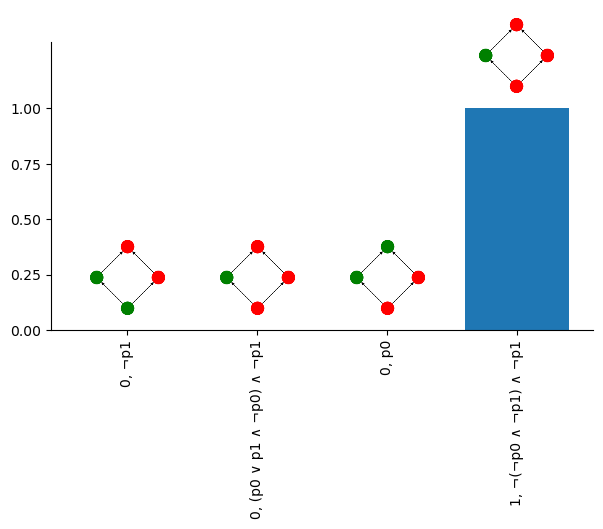

In [274]:
fig, ax = plot_results(
    tn,
    solver,
    figsize=(7,6)
)

fig.subplots_adjust(bottom=0.4)
fig.savefig(f'figures/pandnotq_pknows={prob_knows}.png', dpi=300)

## Low p_know: utterance 'p' w/ belief 'p' (ignorance implicature wrt q)

In [74]:
prob_knows = 0.3

In [78]:
tn = run_boolean_simulation(s, prob_knows)

p(i0, M)

possible meanings: 
 [p0, And(p0, Not(p1))] 
____
possible parses: 
 [p(i0, M), EXH(p(i0, M))] 
____
terms:  [p0, p1] 

p(i0, M)
	 [p0 = True]
	 [p1 = True, p0 = True]


EXH(p(i0, M))
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000.0 [00:36<00:00, 272.05it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1149/1149 [00:00<00:00, 1822.23it/s]


{(0, Not(p1)): np.float64(4.723815371855101e-51),
 (0, Not(p0)): np.float64(4.723815371855101e-51),
 (0, Not(Not(p0))): np.float64(3.7792418613632673e-19),
 (1, Not(p0)): np.float64(1.133282613238798e-50),
 (1, Not(p1)): np.float64(1.133282613238798e-50)}


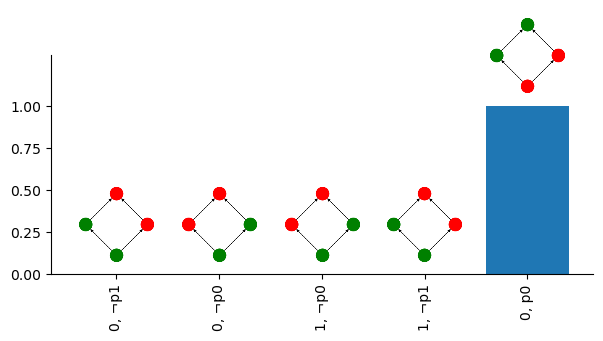

In [161]:
fig, ax = plot_results(
    tn,
    solver
)
# fig.tight_layout()
fig.savefig('figures/p_lowpknow.png', dpi=300)

# $\neg p$

In [275]:
s = 'lnot(p(i0, M))'

## Low p_know

In [276]:
prob_knows = 0.1

In [277]:
tn = run_boolean_simulation(s, prob_knows)

lnot(p(i0, M))

possible meanings: 
 [Not(p0), Not(And(p0, Not(p1)))] 
____
possible parses: 
 [lnot(p(i0, M)), lnot(EXH(p(i0, M)))] 
____
terms:  [p0, p1] 

lnot(p(i0, M))
	 [p0 = False]
	 [p1 = True, p0 = False]


lnot(EXH(p(i0, M)))
	 [p1 = False, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = True, p0 = False]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000.0 [00:40<00:00, 249.60it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 956/956 [00:00<00:00, 1682.79it/s]


{(0, Not(p0)): np.float64(6.675849577230677e-27),
 (1, Implies(Not(p0), And(Not(p1), Not(p1)))): np.float64(1.4747631901827688e-51),
 (1, Implies(Not(p0), p0)): np.float64(3.121974662478175e-51),
 (1, Not(p0)): np.float64(2.060751139395924e-36),
 (1, Or(p1, Not(p0))): np.float64(3.826887572182978e-14)}


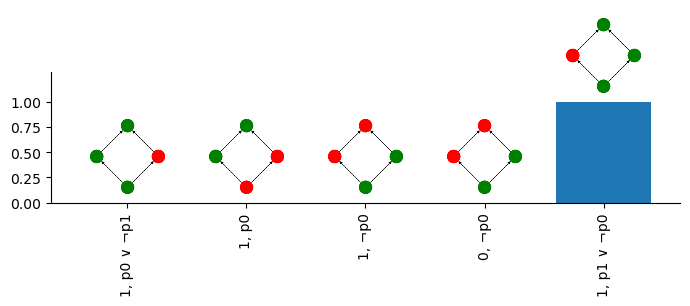

In [179]:
fig, ax = plot_results(
    tn,
    solver
)
fig.tight_layout()
fig.savefig(f'figures/notp_pknow={prob_knows}.png', dpi=300)

## High p_know

In [163]:
prob_knows = 0.9

In [164]:
tn = run_boolean_simulation(s, prob_knows)

lnot(p(i0, M))

possible meanings: 
 [Not(p0), Not(And(p0, Not(p1)))] 
____
possible parses: 
 [lnot(p(i0, M)), lnot(EXH(p(i0, M)))] 
____
terms:  [p0, p1] 

lnot(p(i0, M))
	 [p0 = False]
	 [p1 = True, p0 = False]


lnot(EXH(p(i0, M)))
	 [p1 = False, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = True, p0 = False]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000.0 [01:05<00:00, 151.54it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 956/956 [00:00<00:00, 2437.68it/s]


{(0, Not(p0)): np.float64(6.675849577230677e-27),
 (1, Implies(Not(p0), And(Not(p1), Not(p1)))): np.float64(1.4747631901827688e-51),
 (1, Or(p1, Not(p0))): np.float64(3.826887572182978e-14),
 (1, Not(p0)): np.float64(2.060751139395924e-36),
 (1, Implies(Not(p0), p0)): np.float64(3.121974662478175e-51)}


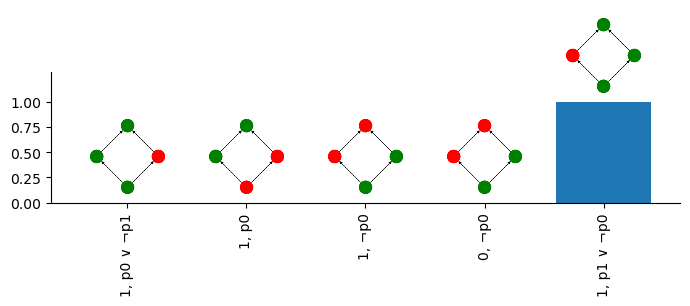

In [185]:
fig, ax = plot_results(
    tn,
    solver
)
fig.tight_layout()
fig.savefig('figures/notp_pknow=0.9.png', dpi=300)

# $p \lor q$

In [278]:
s = 'lor( p(i0, M), p(i1, M) )'

## High p_know: utterance $EXH(p \lor q)$ w/ belief $(p \lor q) \land \neg(p \land q)$

In [279]:
prob_knows = 0.9

In [280]:
tn = run_boolean_simulation(s, prob_knows, n_steps=5*1e4)

lor(p(i0, M), p(i1, M))

possible meanings: 
 [Or(p0, p1), And(Or(p0, p1), Not(And(p1, p0)), Not(And(p0, p1)))] 
____
possible parses: 
 [lor(p(i0, M), p(i1, M)), EXH(lor(p(i0, M), p(i1, M)))] 
____
terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000.0 [03:29<00:00, 238.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3315/3315 [00:02<00:00, 1645.07it/s]


{(0, p0): np.float64(1.305676718018509e-36),
 (0, p1): np.float64(1.701926079842842e-36),
 (0, Or(p1, p0)): np.float64(5.874592294414039e-33),
 (1, And(Not(Implies(Not(p1), p1)), p0)): np.float64(1.1611465607609158e-28),
 (1, And(Not(And(p0, p1)), Or(p1, p0))): np.float64(5.862822444132248e-27),
 (1, And(p1, Implies(Not(Not(p1)), Not(p0)))): np.float64(1.1085182007848135e-28)}


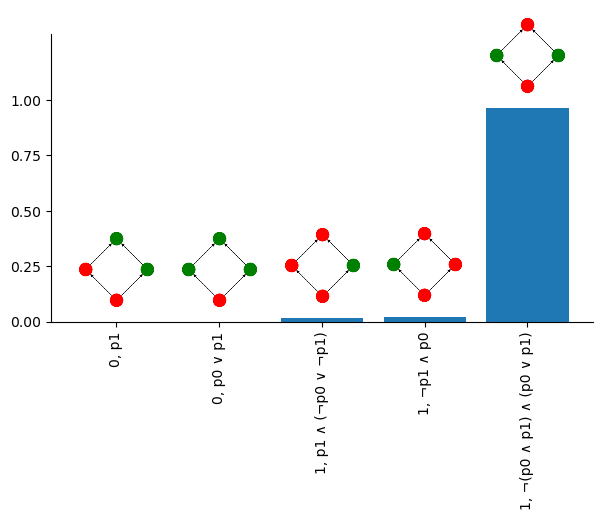

In [281]:
fig, ax = plot_results(
    tn,
    solver,
    figsize=(7,6)
)

fig.subplots_adjust(bottom=0.4)
fig.savefig(f'figures/porq_pknows={prob_knows}.png', dpi=300)

### Enumerative approximation

In [26]:
qud = ProductQUD(
    *m.terms, 
    solver=solver, 
    prob_knows=prob_knows
)

phonform = parse(s, grammar_phon)

print(phonform)

possible_meanings, parses_values = find_phonform_possible_structures(
    phonform=phonform,
    grammar=grammar_utt,
    qud=qud,
    model=m,
    solver=solver,
    unique=True     
)      

print_possible_parses(
    parses_values=parses_values,
    possible_meanings=possible_meanings,
    n_props=n_props,
    solver=solver
)

grammar_belief = define_grammar(
    n_props=n_props,
    EXH=False, 
    index=len(parses_values)
)

lor(p(i0, M), p(i1, M))
terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



In [27]:
possible_hypotheses = list(grammar_belief.enumerate(5))

In [28]:
len(possible_hypotheses)

18936

In [29]:
posterior_scores = analyse_specific_hyps(
    s=s,
    hypotheses=possible_hypotheses,
    n_props=2,
    grammar_phon=grammar_phon,
    grammar_belief=grammar_belief,
    model=m,
    solver=solver,
    qud=qud,
    temp=3,
    likelihood_temperature=0.1,
    prior_temperature=6,
    print_log=False
)

terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18936/18936 [00:33<00:00, 560.62it/s]


  8%|█████████▉                                                                                                                   | 1500/18936 [00:00<00:08, 1979.79it/s]


{(0, And(Not(p1), p0)): np.float64(1.5003439863492586e-27),
 (0, And(Not(p0), p1)): np.float64(1.6686423284428027e-27),
 (0, And(p0, p1)): np.float64(1.6822881399639013e-27),
 (1, And(Not(p1), p0)): np.float64(3.522353193233123e-22),
 (1, Or(Not(Or(p1, Not(p0))), And(Not(p0), p1))): np.float64(4.523280359512848e-27),
 (1, And(Not(p0), p1)): np.float64(3.522353193233123e-22)}


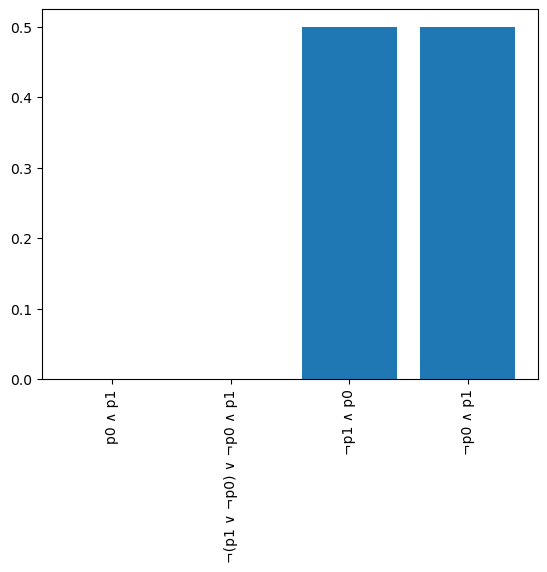

In [30]:
plot_results(posterior_scores, solver=solver, dict_type='scores', first_n=1500)

### Specific likelihoods

In [22]:
hypotheses = [
    'tuple_(u0, p(i0, M))',
    'tuple_(u0, (p(i1, M))',
    'tuple_(u0, lor(p(i0, M),p(i1, M))',
    'tuple_(u1, land(p(i0, M), lnot(p(i1, M)))',
    'tuple_(u1, land(lor(p(i0, M), p(i1, M)), lnot(land(p(i0, M), p(i1, M))))'
]

In [23]:
qud = ProductQUD(
    *m.terms, 
    solver=solver, 
    prob_knows=prob_knows
)

phonform = parse(s, grammar_phon)

print(phonform)

possible_meanings, parses_values = find_phonform_possible_structures(
    phonform=phonform,
    grammar=grammar_utt,
    qud=qud,
    model=m,
    solver=solver,
    unique=True
)      

print_possible_parses(
    parses_values=parses_values,
    possible_meanings=possible_meanings,
    n_props=n_props,
    solver=solver
)

grammar_belief = define_grammar(
    n_props=n_props,
    EXH=False, 
    index=len(parses_values)
)

lor(p(i0, M), p(i1, M))
terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



In [24]:
posterior_scores = analyse_specific_hyps(
    s, 
    hypotheses, 
    n_props, 
    grammar_phon, 
    grammar_belief=grammar_belief,
    model=m,
    solver=solver,
    qud=qud,
    # hypothesis kwargs
    temp=5,
    likelihood_temperature=0.1,
    prior_temperature=6,
)

terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.33it/s]


----------
hyp:  lambda M: tuple_(u0, p(i0, M))
qud:  <QUD.ProductQUD object at 0x7fcfc0c6d7f0>
util: -0.4054651081081645
exp KL:  0.1316872427983538
prob belief:  0.002024999999999999
total lik:  0.00026666666666666635

----------
hyp:  lambda M: tuple_(u0, p(i1, M))
qud:  <QUD.ProductQUD object at 0x7fcfc0c6d7f0>
util: -0.4054651081081645
exp KL:  0.1316872427983538
prob belief:  0.002024999999999999
total lik:  0.00026666666666666635

----------
hyp:  lambda M: tuple_(u0, lor(p(i0, M), p(i1, M)))
qud:  <QUD.ProductQUD object at 0x7fcfc0c6d7f0>
util: -0.0
exp KL:  1.0
prob belief:  0.0004499999999999997
total lik:  0.0004499999999999997

----------
hyp:  lambda M: tuple_(u1, land(p(i0, M), lnot(p(i1, M))))
qud:  <QUD.ProductQUD object at 0x7fcfc0c6d7f0>
util: -0.6931471805599453
exp KL:  0.03125
prob belief:  0.04100625
total lik:  0.0012814453125

----------
hyp:  lambda M: tuple_(u1, land(lor(p(i0, M), p(i1, M)), lnot(land(p(i0, M), p(i1, M)))))
qud:  <QUD.ProductQUD object at 0x7

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1108.37it/s]

{(0, p1): np.float64(1.2017767056466822e-36),
 (0, p0): np.float64(1.2017767056466822e-36),
 (0, Or(p0, p1)): np.float64(1.0630520072208568e-34),
 (1, And(p0, Not(p1))): np.float64(2.6643213075208487e-30),
 (1, And(Or(p0, p1), Not(And(p0, p1)))): np.float64(5.773270892595906e-29)}


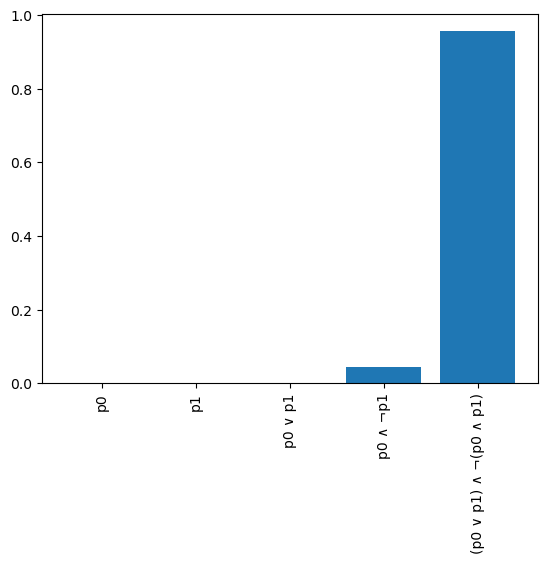

In [25]:
plot_results(posterior_scores, solver=solver, dict_type='scores', first_n=1500)

## Low p_know: utterance $p \lor q$ w/ belief $p \lor q$

In [282]:
prob_knows = 0.1

In [283]:
tn = run_boolean_simulation(s, prob_knows)

lor(p(i0, M), p(i1, M))

possible meanings: 
 [Or(p0, p1), And(Or(p0, p1), Not(And(p1, p0)), Not(And(p0, p1)))] 
____
possible parses: 
 [lor(p(i0, M), p(i1, M)), EXH(lor(p(i0, M), p(i1, M)))] 
____
terms:  [p0, p1] 

lor(p(i0, M), p(i1, M))
	 [p1 = True, p0 = False]
	 [p1 = True, p0 = True]
	 [p1 = False, p0 = True]


EXH(lor(p(i0, M), p(i1, M)))
	 [p1 = True, p0 = False]
	 [p1 = False, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000.0 [00:44<00:00, 226.14it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 827/827 [00:00<00:00, 2828.76it/s]


{(0, And(And(Not(And(Not(p1), p1)), Implies(Not(p0), Not(p0))),
    p0)): np.float64(2.7388679911395703e-37),
 (0, And(And(Not(And(Not(p1), Not(p0))), Implies(Not(p0), p1)),
    p1)): np.float64(7.685992920933448e-37),
 (0, And(And(Not(And(Not(p0), p1)), Implies(Not(p0), Not(p0))),
    Not(p1))): np.float64(5.043619164513478e-52),
 (0, Or(p0, p1)): np.float64(4.0369458395898295e-14),
 (0, And(And(Not(And(p1, p0)), Implies(Not(p1), Not(p0))),
    Not(p1))): np.float64(5.043619164513478e-52),
 (0, And(And(Not(And(Not(p1), p1)), Implies(Not(p0), Not(p0))),
    Not(p0))): np.float64(5.043619164513478e-52),
 (1, Not(p0)): np.float64(6.777131399349993e-51),
 (1, And(And(Not(p0), Implies(Not(p1), Not(p1))), p0)): np.float64(2.7866036111794266e-51),
 (1, p1): np.float64(8.002312566122591e-51),
 (1, And(And(p0, Implies(Not(p1), Not(p1))), p0)): np.float64(9.318656653425372e-52),
 (1, And(And(Not(And(p1, p1)), Implies(Not(p1), Not(p0))),
    Not(p0))): np.float64(1.0087238329026955e-51),
 (1, An

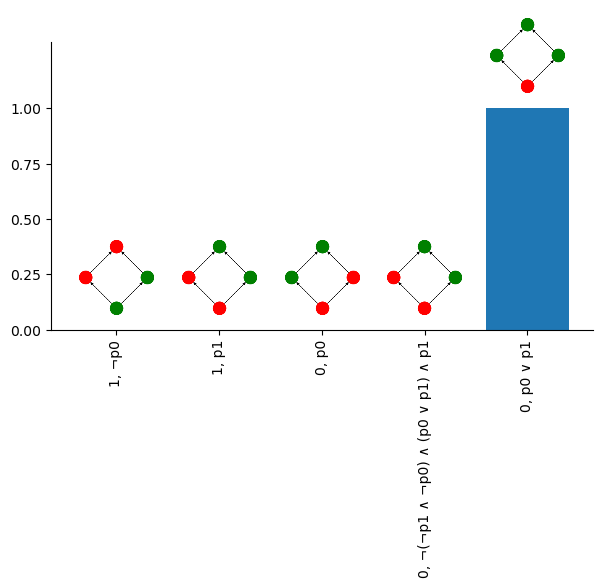

In [284]:
fig, ax = plot_results(
    tn,
    solver,
    figsize=(7,6)
)

fig.subplots_adjust(bottom=0.4)
fig.savefig(f'figures/porq_pknows={prob_knows}.png', dpi=300)

Low range of P(knows):
- P(knows) $< 0.10$: best is belief state 'p or q'
- The following two have the same _likelihood_:
    - Belief "p or q" under utterance "p or q"
    - Belief "(p or q) and not(p and q)" under utterance "EXH(p or q)".
- Because they are equivalent wrt the two components of the likelihood:
    - They fully convey the respective beliefs (KL=0) 
    - They imply neither p nor q.
- However, 'p or q' "wins" because it has a higher prior probability.
- Correct prediction: If the p(know each prop) is low, bare 'p or q' (but doesn't know which) is a plausible interpretation.

Mid range of P(knows)
- P(knows) $(0.10,0.95)$: best are 'p', 'q'
- Desired but unrealized prediction:
    - For the mid range of p(know each prop) the "(p or q) and not(p and q)" interpretation should become most likely
        - This is an ignorance implicature meaning: "Exactly one is true, but I don't know which one"
    - The 'full knowledge' interpretations ('p and not q', 'q and not p') would be too strange to be right
        - These are: 'p and not q' and 'not p and q' under the utterance 'EXH(p or q)'
        - What is strange for real speakers about the 'full knowledge' interpretations given phonform 'p or q'?
            - If belief state was 'p and not q', they would not say 'EXH(p or q)', because 'EXH(p or q)' leaves a false state open (namely, p=False and q=True).
    - The 'partial beliefs' interpretations ('p' and 'q', under utterance 'p or q') _should_ be implausible for this mid range
        - If belief state was 'p', the speaker would just convey 'p'.
        - Saying 'p or q' leaves a false state open (p=False, q=True).
- The core of the problem:
    - Belief state "(p or q) and not(p and q)" has the same prob as "p or q"
    - But the former might be more probable in context! For instance if I expect the speaker to have at least some information.
    - This suggests a more sophisticated encoding for the listener's prior over belief states.
    - At the moment, this is just $\prod_i P(k_i)$, with $\forall i k_i = \beta$
    - I want instead a prior where _excluding_ some possibilities gives a higher probability.

Very high range of P(knows):
- P(knows) $> 0.95$: best are 'p and not q', 'q and not p' under utterance 'EXH(p or q)'
- Correct prediction: If the p(know each prop) is high enough, 'p or q' is interpreted as the speaker knowing that only one is true, but not saying which one.
- This means "Exactly one is true, but I'm not telling you which"

# $p \lor (p \land q)$

## Parse $(p \land \neg q) \lor (p \land q)$ w/ belief $p$

I expect all the probability to be concentrated on "p", with the parse "EXH(p) or (p and q)"

In [285]:
s = 'lor(p(i0, M), land(p(i1, M), p(i0, M)))'
prob_knows = 0.8

In [288]:
tn = run_boolean_simulation(s, prob_knows,n_steps=1e5)

lor(p(i0, M), land(p(i1, M), p(i0, M)))
lor(p(i0, M), land(p(i1, M), p(i0, M))) has been excluded because failed hurford!
EXH(lor(p(i0, M), land(p(i1, M), p(i0, M)))) has been excluded because failed hurford!
lor(p(i0, M), EXH(land(p(i1, M), p(i0, M)))) has been excluded because failed hurford!
lor(p(i0, M), land(EXH(p(i1, M)), p(i0, M))) has been excluded because failed hurford!
lor(p(i0, M), land(p(i1, M), EXH(p(i0, M)))) has been excluded because failed hurford!

possible meanings: 
 [Or(And(p0, Not(p1)), And(p1, p0))] 
____
possible parses: 
 [lor(EXH(p(i0, M)), land(p(i1, M), p(i0, M)))] 
____
terms:  [p0, p1] 

lor(EXH(p(i0, M)), land(p(i1, M), p(i0, M)))
	 [p1 = False, p0 = True]
	 [p1 = True, p0 = True]


Synonymy table:
          0
    0 True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000.0 [06:33<00:00, 254.22it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11811/11811 [00:03<00:00, 3188.24it/s]


{(0, Not(p0)): np.float64(7.418363755566424e-51),
 (0, p1): np.float64(7.418363755566424e-51),
 (0, p0): np.float64(1.9243139208721862e-20)}


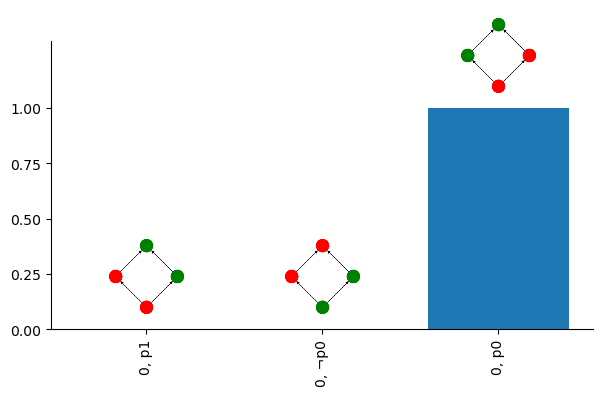

In [289]:
fig, ax = plot_results(
    tn,
    solver,
    figsize=(7,6)
)

fig.subplots_adjust(bottom=0.4)
fig.savefig(f'figures/porpandq_pknows={prob_knows}.png', dpi=300)

### Analysis of specific likelihoods

In [36]:
s = 'lor(p(i0, M), land(p(i1, M), p(i0, M)))'
hypotheses = [
    'tuple_(u0, p(i0, M))',
    'tuple_(u0, p(i1, M))',
    'tuple_(u0, lor(p(i1, M), p(i0, M)))',
    'tuple_(u0, land(lnot(p(i1, M)), p(i0, M)))',
    'tuple_(u0, lor(p(i0, M), land(p(i1, M), p(i0, M)))'
]

phonform, possible_meanings, parses_values, grammar_belief = get_info(s)

lor(p(i0, M), land(p(i1, M), p(i0, M)))


In [37]:
possible_meanings, parses_values = find_phonform_possible_structures(
    phonform=phonform,
    grammar=grammar_phon,
    qud=qud,
    model=m,
    solver=solver
)

In [38]:
possible_meanings

[Or(And(p0, Not(p1)), And(p1, p0))]

In [39]:
analyse_specific_hyps(
    s=s,
    hypotheses=hypotheses,
    n_props=n_props,
    grammar_phon=grammar_phon,
    grammar_belief=grammar_belief,
    qud=qud,
    temp=5,
    model=m,
    solver=solver,
    likelihood_temperature=0.1,
    prior_temperature=6,
    print_log=True,
)

terms:  [p0, p1] 

lor(EXH(p(i0, M)), land(p(i1, M), p(i0, M)))
	 [p1 = False, p0 = True]
	 [p1 = True, p0 = True]


Synonymy table:
          0
    0 True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 535.02it/s]


----------
hyp:  lambda M: tuple_(u0, p(i0, M))
qud:  <QUD.ProductQUD object at 0x7f6870db2f00>
util: -0.0
exp KL:  1.0
prob belief:  0.006399999999999998
total lik:  0.006399999999999998

----------
hyp:  lambda M: tuple_(u0, p(i1, M))
qud:  <QUD.ProductQUD object at 0x7f6870db2f00>
util: -inf
exp KL:  0.0
inconsistent prob:  0.0


----------
hyp:  lambda M: tuple_(u0, lor(p(i1, M), p(i0, M)))
qud:  <QUD.ProductQUD object at 0x7f6870db2f00>
util: -inf
exp KL:  0.0
inconsistent prob:  0.0


----------
hyp:  lambda M: tuple_(u0, land(lnot(p(i1, M)), p(i0, M)))
qud:  <QUD.ProductQUD object at 0x7f6870db2f00>
util: -0.6931471805599453
exp KL:  0.03125
prob belief:  0.025600000000000005
total lik:  0.0008000000000000001

----------
hyp:  lambda M: tuple_(u0, lor(p(i0, M), land(p(i1, M), p(i0, M))))
qud:  <QUD.ProductQUD object at 0x7f6870db2f00>
util: -0.0
exp KL:  1.0
prob belief:  0.006399999999999998
total lik:  0.006399999999999998


{lambda M: tuple_(u0, p(i0, M)): -50.81319946436979,
 lambda M: tuple_(u0, p(i1, M)): -92.40203029796761,
 lambda M: tuple_(u0, lor(p(i1, M), p(i0, M))): -93.151998576356,
 lambda M: tuple_(u0, land(lnot(p(i1, M)), p(i0, M))): -72.69340032964689,
 lambda M: tuple_(u0, lor(p(i0, M), land(p(i1, M), p(i0, M)))): -52.31313602114654}

Problem:
- An utterance of 'p or (p and q)' might be (among others):
    1. A non exhaustified utterance meaning 'p', with speaker's belief 'p' (UNLIKELY)
    2. An exhaustified utterance 'EXH(p) or (p and q)', with speaker's belief '(p and not q) or (p and q)' -> 'p' (Ignorance implicature)
- The point of the example is that to express just belief state 'p', a speaker would use this longer expression rather than just saying 'p'.

# $\neg (p \lor q)$

## Parse $(p \land \neg q) \lor (p \land q)$ w/ belief $p$

I expect all the probability to be concentrated on "p", with the parse "EXH(p) or (p and q)"

In [290]:
s = 'lnot(lor(p(i0, M), p(i1, M)))'
prob_knows = 0.8

In [291]:
tn = run_boolean_simulation(s, prob_knows,n_steps=1e5)

lnot(lor(p(i0, M), p(i1, M)))
EXH(lnot(lor(p(i0, M), p(i1, M)))) has been excluded because failed hurford!

possible meanings: 
 [Not(Or(p0, p1)), Not(And(Or(p0, p1), Not(And(p1, p0)), Not(And(p0, p1))))] 
____
possible parses: 
 [lnot(lor(p(i0, M), p(i1, M))), lnot(EXH(lor(p(i0, M), p(i1, M))))] 
____
terms:  [p0, p1] 

lnot(lor(p(i0, M), p(i1, M)))
	 [p1 = False, p0 = False]


lnot(EXH(lor(p(i0, M), p(i1, M))))
	 [p1 = False, p0 = False]
	 [p1 = True, p0 = True]


Synonymy table:
          0     1
    0 True  False
    1 False True 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000.0 [05:24<00:00, 308.55it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7930/7930 [00:02<00:00, 3276.28it/s]


{(0, Not(p0)): np.float64(1.2664935131434045e-50),
 (0, Not(p1)): np.float64(6.609010760532878e-51),
 (0, And(Implies(Not(p0), Not(p0)), Not(And(Not(p1), p0)))): np.float64(5.24020744081903e-52),
 (0, And(Implies(p0, p0), Not(And(Not(p1), p1)))): np.float64(4.979338607059159e-52),
 (0, And(Implies(p0, p0), Not(And(Not(p0), p1)))): np.float64(4.979338607059159e-52),
 (0, Not(Implies(Not(p0), Not(Or(p0, Not(p1)))))): np.float64(1.0439540371708816e-14),
 (0, p1): np.float64(6.609010760532878e-51),
 (1, Not(p1)): np.float64(6.609010760532878e-51),
 (1, Not(p0)): np.float64(6.609010760532878e-51)}


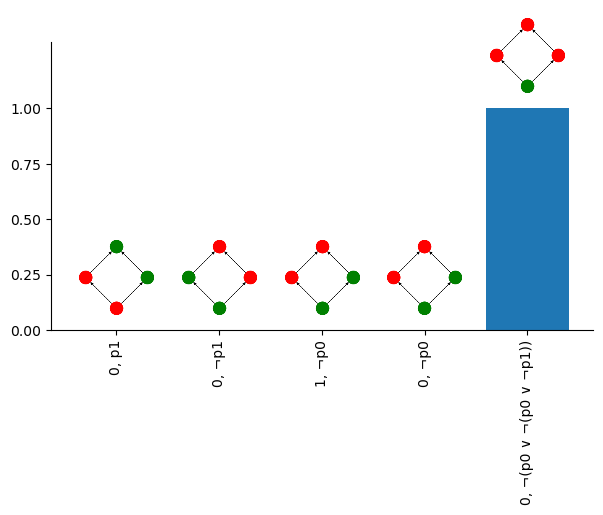

In [292]:
fig, ax = plot_results(
    tn,
    solver,
    figsize=(7,6)
)

fig.subplots_adjust(bottom=0.4)
fig.savefig(f'figures/notporq_pknows={prob_knows}.png', dpi=300)